# Load libraries

In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
library(readxl)
library(treemapify)
library(treemap)
library(tidyverse)
library(cowplot)

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



# Load data

In [3]:
%%R -o best_hits
best_hits <- read_csv("data/Ecoli_pangenome_best_hits.csv")

Rows: 7262 Columns: 25
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (8): qseqid, sseqid, component, cinful_id, pephash, sample, contig, seq
dbl (13): pident, length, mismatch, gapopen, qstart, qend, sstart, send, eva...
lgl  (4): hmmerHit, verified, allStandardAA, signalMatch

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


The primary goal here is to get an idea for how many _E. coli_ genome assemblies have microcins. In this regard, we split assemblies into three classes:

1. No microcin
   - nothing that remotely resembled a verified class II (to save the amount of times I type this, I will just refer to them as microcins)
2. verified 
   -  these assemblies had a protein with the exact same sequence as the verified microcin sequences we already know about
3. novel
   - it should be noted that this is pretty loose usage of novel, it really means that the assembly contains something remotely similar to a verified microcin, though it is agnostic of how well the match is or any other components that were identified in the assembly.

What we will do is make a treemap to make three rectangles whose areas correspond to the number of assemblies that belong to each of these three groups. For verified and novel, they also consist of different protein sequences, so they will have sub rectangles whose areas correspond the amount of assemblies that had a given protein sequence.

## Data to be visualized
This contains, the sequence, unique identifier, whether or not it was verified. A somewhat hacky thing I have to do is manually input the amount of assemblies that had no assemblies, because those assemblies don't make it to the final output file.

First, it would be very helpful to know how many assemblies there were total in the analysis.

In [4]:
!wc -l data/Ecoli_samples.txt

1224 data/Ecoli_samples.txt


In [5]:
%%R
num_samples <- 1224
num_samples

[1] 1224


In [27]:
%%R

n_genome <- best_hits %>%
    filter(component == "microcins.verified") %>%
    count(sample) %>%
    nrow()

n_put <- best_hits %>%
    filter(component == "microcins.verified") %>%
    count(pephash) %>%
    nrow()

print("Number of genomes with PUTATIVE microcins identified by Cinful:")
print(n_genome)

print("Number of unique peptides identified as microcins by Cinful:")
print(n_put)
#Number of putative microcins identified (no check for HMMer hits)


[1] "Number of genomes with PUTATIVE microcins identified by Cinful:"
[1] 313
[1] "Number of unique peptides identified as microcins by Cinful:"
[1] 101


In [7]:
%%R

genomes_w_microcins <- best_hits %>%
    filter(component == "microcins.verified") %>%
    filter(hmmerHit == TRUE) %>%
    count(sample) %>%
    nrow()


tot_uniq_peptides <- best_hits %>%
    filter(component == "microcins.verified") %>%
    filter(hmmerHit == TRUE) %>%
    count(pephash) %>%
    nrow()

print("Number of TOTAL sample genomes with HMMer verified microcins:")
print(genomes_w_microcins)

print("Number of unique microcins verified by HMMer:")
print(tot_uniq_peptides)

#Number of genomes with microcins that pass HMMer

[1] "Number of TOTAL sample genomes with HMMer verified microcins:"
[1] 288
[1] "Number of unique microcins verified by HMMer:"
[1] 64


In [111]:
%%R 

n_ver_genomes <- best_hits %>%
    filter(component == "microcins.verified") %>%
    filter(hmmerHit == TRUE) %>%
    filter(verified == TRUE) %>%
    count(sample) %>%
    nrow()

print("Number of sample genomes with KNOWN microcins:")
print(n_ver_genomes)

n_ver_microcins <- best_hits %>%
    filter(component == "microcins.verified") %>%
    filter(hmmerHit == TRUE) %>%
    filter(verified == TRUE) %>%
    count(pephash) %>%
    nrow()

print("Number of KNOWN microcins identified:")
print(n_ver_microcins)

[1] "Number of sample genomes with KNOWN microcins:"
[1] 211
[1] "Number of KNOWN microcins identified:"
[1] 6
# A tibble: 6 × 2
  pephash                                                                     n
  <chr>                                                                   <int>
1 v1_PLS_8255457454971611862435efee037184a7324d556c33315d633ba5b49f0b5394     4
2 v1_PLS_8e751f217be82f38b463fed36edac3961f564d06d6a0290ed11ac9c46d6a5d69     8
3 v1_PLS_9d4d5884be3f55eea558ad570cf5724a7bed8ab3a6bfeffa3601882987f2a72c     6
4 v1_PLS_f023a3e09cddc0f31fea8bcbba5cca016d488f4c338a149c9d3ae683bee53330    27
5 v1_PLS_f46b02a1bfa1c3d276b482deec9926ec13d8dc5b8b8eceeea84e4fda83be41e6   170
6 v1_PLS_ff10c10f7e957c977390dcd2776f9a12a1d1f324700543820a861d0a6aced3fe     5


In [41]:
%%R

n_unk_genomes <- best_hits %>%
    filter(component == "microcins.verified") %>%
    filter(hmmerHit == TRUE) %>%
    filter(verified == FALSE) %>%
    count(sample) %>%
    nrow()

print("Number of sample genomes with UNKNOWN microcins:")
print(n_unk_genomes)

n_unk_microcins <- best_hits %>%
    filter(component == "microcins.verified") %>%
    filter(hmmerHit == TRUE) %>%
    filter(verified == FALSE) %>%
    count(pephash) %>%
    nrow()

print("Number of UNKNOWN microcins identified:")
print(n_unk_microcins)


[1] "Number of sample genomes with UNKNOWN microcins:"
[1] 113
[1] "Number of UNKNOWN microcins identified:"
[1] 58


In [46]:
%%R
count_of_hmmer_hits <- best_hits %>%
	filter(component == "microcins.verified") %>%
	filter(hmmerHit == TRUE) %>%
	count(sample) %>%
    nrow()

print(count_of_hmmer_hits)

[1] 288


In [50]:
%%R
verified_microcins <- best_hits %>%
	filter(component == "microcins.verified") %>%
	filter(hmmerHit == TRUE) %>%
	filter(verified == TRUE) %>%
    count(sample) %>%
    nrow()

verified_microcins

[1] 211


In [51]:
%%R

verified_microcin_peptides <- best_hits %>%
	filter(component == "microcins.verified") %>%
	filter(hmmerHit == TRUE) %>%
	filter(verified == TRUE) %>%
	count(pephash) %>%
    nrow()

verified_microcin_peptides

[1] 6


In [52]:
%%R
novel_microcins <- best_hits %>%
	filter(component == "microcins.verified") %>%
	filter(hmmerHit == TRUE) %>%
	filter(verified == FALSE) %>%
	count(sample) %>%
    nrow()

novel_microcins

[1] 113


In [53]:
%%R
samples_w_microcins <- best_hits %>%
	filter(component == "microcins.verified") %>%
	filter(hmmerHit == TRUE) %>%
	count(sample) %>%
    nrow()

samples_w_microcins

[1] 288


In [54]:
%%R


samples_wo_microcins <- num_samples - as.integer(samples_w_microcins)


print(num_samples)
print(samples_w_microcins)
print(samples_wo_microcins)

[1] 1224
[1] 288
[1] 936


In [109]:
%%R

A <- best_hits %>%
    filter(component == "microcins.verified") %>%
    filter(hmmerHit == TRUE) %>%
    count(sample)
A
#288

B <- best_hits %>%
    filter(component == "microcins.verified") %>%
    filter(hmmerHit == TRUE) %>%
    filter(verified == TRUE) %>%
    count(sample)
B
#211

C <- best_hits %>%
    filter(component == "microcins.verified") %>%
    filter(hmmerHit == TRUE) %>%
    filter(verified == FALSE) %>%
    count(sample)
C
#113


library(dplyr)

B[,1]
C[,1]

inner_join(B[,1], C[,1])


#36 genomes have both novel and verified microcins


Joining, by = "sample"
# A tibble: 36 × 1
   sample                                               
   <chr>                                                
 1 data/GCA_902837665.1/GCA_902837665.1_POSS_77_genomic 
 2 data/GCA_902838695.1/GCA_902838695.1_POSS_67_genomic 
 3 data/GCA_902838985.1/GCA_902838985.1_M710019_genomic 
 4 data/GCA_902839235.1/GCA_902839235.1_48_5_R19_genomic
 5 data/GCA_902839255.1/GCA_902839255.1_H331_genomic    
 6 data/GCA_902839405.1/GCA_902839405.1_C2_41_genomic   
 7 data/GCA_902839665.1/GCA_902839665.1_TA209_genomic   
 8 data/GCA_902839675.1/GCA_902839675.1_POSS_70_genomic 
 9 data/GCA_902840075.1/GCA_902840075.1_E2038_genomic   
10 data/GCA_902840495.1/GCA_902840495.1_TA361_genomic   
# … with 26 more rows


In [56]:
%%R

novel_microcin_peptides <- best_hits %>%
	filter(component == "microcins.verified") %>%
	filter(hmmerHit == TRUE) %>%
	filter(verified == FALSE) %>%
	count(pephash) %>%
	select(n) %>%
	summarise(n_unique_peptides = n()) %>%
	as.integer()

novel_microcin_peptides

[1] 58


In [57]:
%%R
best_hits %>%
	filter(component == "microcins.verified") %>%
	group_by(pephash,verified,sample,seq) %>% summarise(n = n()) %>%
	ungroup() %>%
	mutate(verified = as.factor(verified)) %>%
	add_row(pephash=NA, verified="no_microcin",n=samples_wo_microcins) %>%
	write_csv("data/supplemental/Ecoli_microcin_treemap_data.csv")

`summarise()` has grouped output by 'pephash', 'verified', 'sample'. You can
override using the `.groups` argument.


## initial treemap

I set up two treemap figures, one with just the main three classes, and the other with the second subdivision. This isn't something that should be necessary, but it ended up being the only way for me to get the final figure to my liking.

`summarise()` has grouped output by 'pephash', 'verified'. You can override
using the `.groups` argument.
`summarise()` has grouped output by 'pephash', 'verified'. You can override
using the `.groups` argument.
$tm
      verified
1        FALSE
2        FALSE
3        FALSE
4        FALSE
5        FALSE
6        FALSE
7        FALSE
8        FALSE
9        FALSE
10       FALSE
11       FALSE
12       FALSE
13       FALSE
14       FALSE
15       FALSE
16       FALSE
17       FALSE
18       FALSE
19       FALSE
20       FALSE
21       FALSE
22       FALSE
23       FALSE
24       FALSE
25       FALSE
26       FALSE
27       FALSE
28       FALSE
29       FALSE
30       FALSE
31       FALSE
32       FALSE
33       FALSE
34       FALSE
35       FALSE
36       FALSE
37       FALSE
38       FALSE
39       FALSE
40       FALSE
41       FALSE
42       FALSE
43       FALSE
44       FALSE
45       FALSE
46       FALSE
47       FALSE
48       FALSE
49       FALSE
50       FALSE
51       FALSE
52  

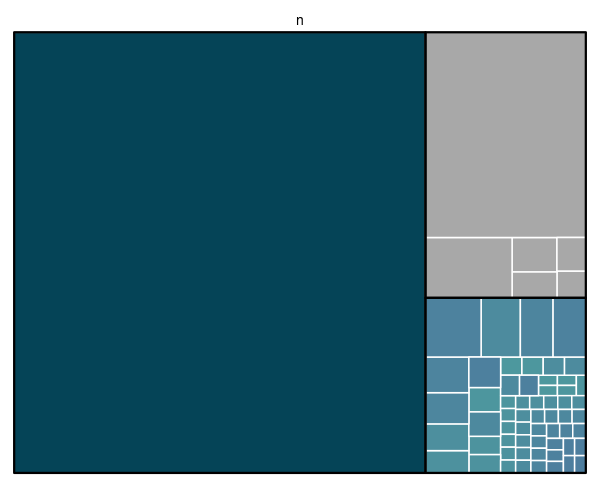

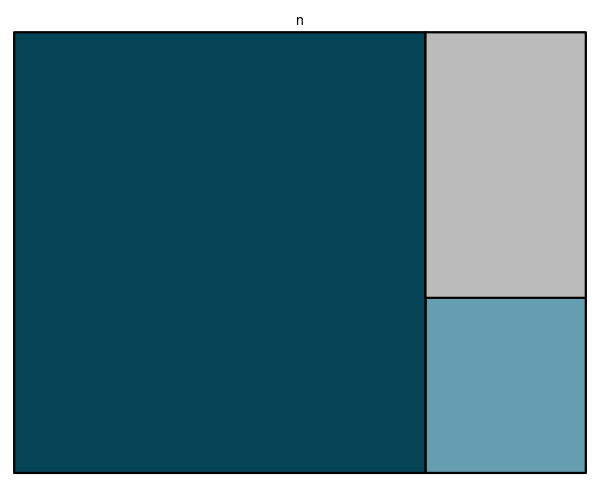

In [58]:
%%R -w 600
best_hits_TM <- best_hits %>%
	filter(component == "microcins.verified") %>%
	filter(hmmerHit == TRUE) %>%
	group_by(pephash,verified,sample) %>% summarise(n = n()) %>%
	ungroup() %>%
	mutate(verified = as.factor(verified)) %>%
	add_row(pephash=NA, verified="no_microcin",n=samples_wo_microcins) %>% 
	treemap(
		index = c("verified","pephash"),
        vSize = "n",
		border.col=c("black","white"),
    	border.lwds=c(3,2),
		fontsize.labels=c(0,0),
		palette = c("#659eb0","#054457","#BBBBBB")
	)

best_hits_TM_verified <- best_hits %>%
	filter(component == "microcins.verified") %>%
	filter(hmmerHit == TRUE) %>%
	group_by(pephash,verified,sample) %>% summarise(n = n()) %>%
	ungroup() %>%
	mutate(verified = as.factor(verified)) %>%
	add_row(pephash=NA, verified="no_microcin",n=samples_wo_microcins) %>% 
	treemap(
		index = c("verified"),
        vSize = "n",
		border.col=c("black","white"),
    	border.lwds=c(3,2),
		fontsize.labels=c(0,0),
		palette = c("#659eb0","#054457","#BBBBBB")
	)

best_hits_TM

The next is less than fun, but just a way of wrangling data so that the final figure looks nice.

In [59]:
%%R
best_hits_TM_data <- best_hits_TM$tm %>%
	mutate(x1 = x0 + w,
         y1 = y0 + h) %>% 
  # get center coordinates for labels
  mutate(x = (x0+x1)/2,
         y = (y0+y1)/2) %>% 
  # mark primary groupings and set boundary thickness
  mutate(primary_group = ifelse(is.na(verified), 2, .5)) %>% 
  # remove colors from primary groupings (since secondary is already colored)
  mutate(color = ifelse(is.na(verified), NA, color))


best_hits_TM_data_verified <- best_hits_TM_verified$tm %>%
	mutate(x1 = x0 + w,
         y1 = y0 + h) %>% 
  # get center coordinates for labels
  mutate(x = (x0+x1)/2,
         y = (y0+y1)/2) %>% 
  # mark primary groupings and set boundary thickness
  mutate(primary_group = ifelse(is.na(verified), 1,1 )) %>% 
  # remove colors from primary groupings (since secondary is already colored)
  mutate(color = ifelse(is.na(verified), NA, color))

best_hits_TM_data <- as_tibble(best_hits_TM_data) %>%
	mutate(color =
		case_when(
			verified == "FALSE" ~ "#659eb0",# "#659eb0",
			verified == "TRUE" ~ "#F4B3A5",#"#C8E3B9",#"#054457",
			verified == "no_microcin" ~ "#BBBBBB"
		)
	)

best_hits_TM_data

# A tibble: 68 × 17
   verified pephash     vSize vColor stdErr vColorValue level    x0    y0      w
   <fct>    <fct>       <dbl>  <dbl>  <dbl> <lgl>       <int> <dbl> <dbl>  <dbl>
 1 FALSE    <NA>          145    145    145 NA              1 0.719 0     0.281 
 2 FALSE    v1_PLS_030…     2      2      2 NA              2 0.851 0.222 0.0373
 3 FALSE    v1_PLS_071…     1      1      1 NA              2 0.917 0.199 0.0331
 4 FALSE    v1_PLS_162…     1      1      1 NA              2 0.917 0.175 0.0331
 5 FALSE    v1_PLS_17d…     1      1      1 NA              2 0.950 0.199 0.0331
 6 FALSE    v1_PLS_1a8…     2      2      2 NA              2 0.888 0.222 0.0373
 7 FALSE    v1_PLS_1cd…     1      1      1 NA              2 0.950 0.175 0.0331
 8 FALSE    v1_PLS_220…     4      4      4 NA              2 0.795 0.138 0.0555
 9 FALSE    v1_PLS_297…     1      1      1 NA              2 0.983 0.175 0.0166
10 FALSE    v1_PLS_35f…     1      1      1 NA              2 0.851 0.146 0.0263
# … with

Now we can plug this into ggplot with our first intermediate plot

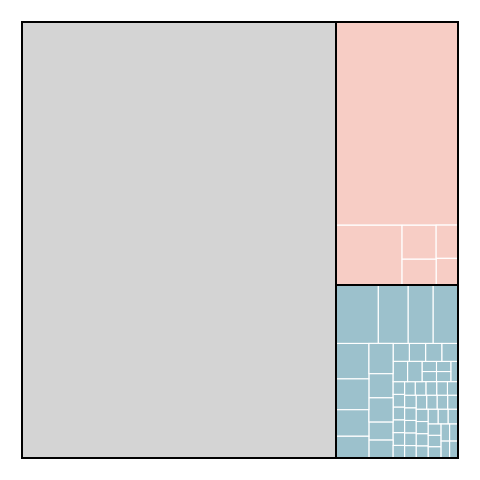

In [60]:
%%R 

p1 <- ggplot(best_hits_TM_data, aes(xmin = x0, ymin = y0, xmax = x1, ymax = y1)) + 
  # add fill and borders for groups and subgroups

  geom_rect(aes(fill = color, size = primary_group),
            show.legend = FALSE, color = "white", alpha = 0.4) +
  scale_fill_identity() +
  # set thicker lines for group borders
  scale_size(range = range(best_hits_TM_data$primary_group)) +
  geom_rect(aes(
                xmin = best_hits_TM_data_verified$x0[1], 
                ymin = best_hits_TM_data_verified$y0[1], 
                xmax = best_hits_TM_data_verified$x1[1], 
                ymax = best_hits_TM_data_verified$y1[1], 
            ),
                fill = NA, color = "black") +
  geom_rect(aes(xmin = best_hits_TM_data_verified$x0[2], 
                ymin = best_hits_TM_data_verified$y0[2], 
                xmax = best_hits_TM_data_verified$x1[2], 
                ymax = best_hits_TM_data_verified$y1[2]
                ),
                 fill = NA, color = "black") +
  geom_rect(aes(xmin = best_hits_TM_data_verified$x0[3], 
                ymin = best_hits_TM_data_verified$y0[3], 
                xmax = best_hits_TM_data_verified$x1[3], 
                ymax = best_hits_TM_data_verified$y1[3]),
                fill = NA, color = "black") +
  
  theme_nothing() 



p1 
# ggsave("best_hits_treemap.png")


Now we just annotate it with numbers that represent the size of the large rectangles and the smaller sub-rectangles. I did this manually, though probably it is better to figure out a way to get these values from the dataset.

Alright, I'm back and definitely need to at least figure out a way to get the other values non-manually. There isn't really a way around manually typing 818, though honestly the only hardcoded value should be total number of assemblies. 

In [21]:
%%R
paste("assemblies:",as.character(samples_wo_microcins))

[1] "assemblies: 936"


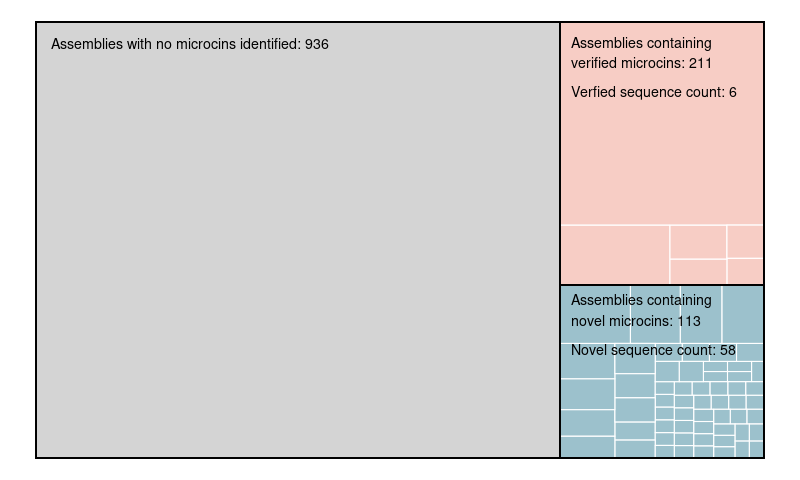

In [110]:
%%R -w 800
microcin_treemap <- p1  + 
	annotate("text",x = 0.02, y = 0.95, 
		label = paste("Assemblies with no microcins identified:", as.character(samples_wo_microcins)), 
		size = 5, hjust = 0) +
	annotate("text", x = 0.02,y = 0.91, label = paste("", as.character()), 
        size = 5,hjust = 0) +
	annotate("text",x = 0.735, y = 0.93, 
		label =  paste("Assemblies containing\nverified microcins:", as.character(verified_microcins)),
		size = 5, hjust = 0) +
	annotate("text",x = 0.735, y = 0.84, 
		label = paste("Verfied sequence count:", as.character(verified_microcin_peptides)),
		size = 5, hjust = 0) +
	annotate("text",x = 0.735, y = 0.3 +0.04, 
		label =  paste("Assemblies containing\nnovel microcins:", as.character(novel_microcins)),
		size = 5, hjust = 0) +
	annotate("text",x = 0.735, y = 0.21 +0.04, 
		label = paste("Novel sequence count:", as.character(novel_microcin_peptides)),
		size = 5, hjust = 0) #+


microcin_treemap
#ggsave("best_hits_treemap_annotated.svg")

In [68]:
%%R
microcin_treemap
ggsave("testing_01_best_hits_treemap_annotated.svg")

#Final save here:
#ggsave("plots/01_best_hits_treemap_annotated.svg")

R[write to console]: Saving 6.67 x 6.67 in image



# Data for table

So I saved the data needed to make the figure, but that isn't necessarily the best for what I would like to have in the manuscript or for a supplemental. I want the novel peptides, as well as various metrics from BLAST and whatnot

In [69]:
%%R
best_hits %>%
	filter(component == "microcins.verified") %>%
	filter(verified == FALSE) %>%
	filter(hmmerHit == TRUE)

# A tibble: 145 × 25
   qseqid        sseqid pident length mismatch gapopen qstart  qend sstart  send
   <chr>         <chr>   <dbl>  <dbl>    <dbl>   <dbl>  <dbl> <dbl>  <dbl> <dbl>
 1 v1_PLS_987b1… E492_…   80.4     92       18       0      1    92      1    92
 2 v1_PLS_07196… L_tr_…   99.0    102        1       0      1   102      4   105
 3 v1_PLS_718e5… V_sp_…   81.2     16        3       0      1    16      1    16
 4 v1_PLS_e4c44… H47_s…  100       75        0       0     23    97      1    75
 5 v1_PLS_e4c44… H47_s…  100       75        0       0     23    97      1    75
 6 v1_PLS_e4c44… H47_s…  100       75        0       0     23    97      1    75
 7 v1_PLS_e4c44… H47_s…  100       75        0       0     23    97      1    75
 8 v1_PLS_e4c44… H47_s…  100       75        0       0     23    97      1    75
 9 v1_PLS_e4c44… H47_s…  100       75        0       0     23    97      1    75
10 v1_PLS_e4c44… H47_s…  100       75        0       0     23    97      1    75
# … wit

In [70]:
%%R
best_hits %>%
	filter(component == "microcins.verified") %>%
	filter(verified == FALSE) %>%
	filter(hmmerHit == TRUE) %>%
	count(seq, sseqid, pident) %>%
	write_csv("data/supplemental/Ecoli_microcin_novel.csv")